## Goal 2: Random Forest & Sentence-BERT

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


In [3]:
current = pd.read_csv("../data/processed/Goal2.csv")

<br>
<br>

## 1. Random Forest Classifier

#### Filter out Yes and No (Random Forest)

In [4]:
df_rf = current[current["Do you currently have a mental health disorder?"].isin(["Yes","No"])].copy()

#### Create binary target

In [5]:
df_rf["Do you currently have a mental health disorder?"] = (df_rf["Do you currently have a mental health disorder?"] == "Yes").astype(int)

print(df_rf["Do you currently have a mental health disorder?"].value_counts())
print(df_rf.shape)

Do you currently have a mental health disorder?
1    1362
0    1123
Name: count, dtype: int64
(2485, 28)


#### Extract features and target

In [6]:
y = df_rf["Do you currently have a mental health disorder?"] # target
X = df_rf.drop(columns=["Do you currently have a mental health disorder?"]) #features

#### Encode categorical features
##### (randomForest needs numerical features)

In [7]:
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

#### Train/test split

In [8]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=5)

#### Classifier

In [9]:
rf = RandomForestClassifier(n_estimators=300,max_depth=None,class_weight="balanced",random_state=5)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=5)

#### Predictions on a confusion matrix and accuracy score

In [10]:
y_pred = rf.predict(X_test)
confusion_matrix_result = confusion_matrix(y_test.values, y_pred, labels=[1,0]) 

print("Confusion matrix:\n%s" % confusion_matrix_result)
print("")
print("  tp, fn")
print("  fp, tn")

tp, fn = confusion_matrix_result[0]
fp, tn = confusion_matrix_result[1]
print("")
accuracy = (tp + tn) / (tp + fn + fp + tn)
print("accuracy: ", round(accuracy,3))

Confusion matrix:
[[287   7]
 [ 26 177]]

  tp, fn
  fp, tn

accuracy:  0.934


#### Feature importance visualized on a barchart

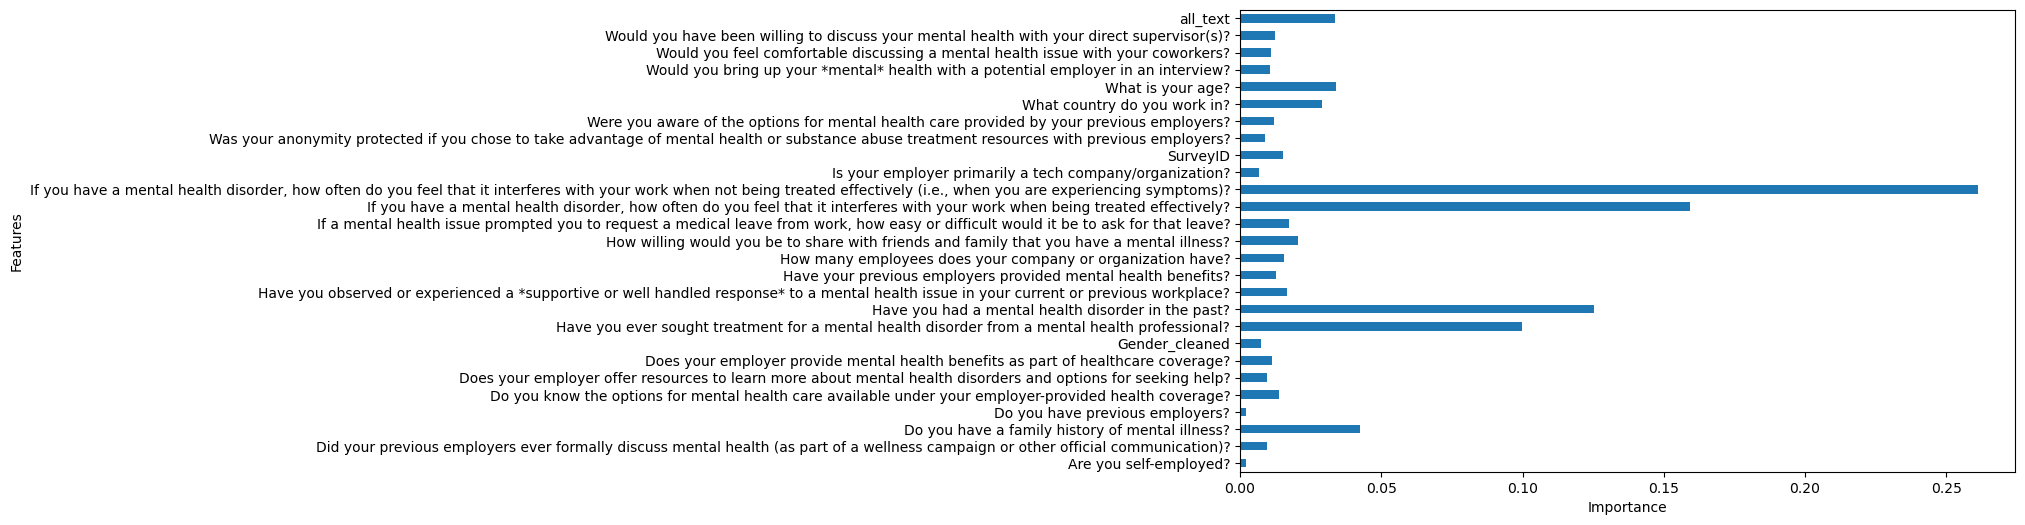

In [11]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.plot(kind='barh',figsize=(10,6))
plt.xlabel("Importance")
plt.ylabel("Features")
#plt.xticks(rotation=90)
plt.show()


<br>
<br>

## Sentence-BERT

In [12]:
copy = current.copy()

In [14]:
texts = copy["all_text"]

# <span style="color:red">TODO: finish Sentence-BERT using all_text column </span>
